In [1]:
import os, glob, subprocess, datetime

import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scores import *
from utils import _fDepth

from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline
from statsmodels.distributions.empirical_distribution import ECDF

path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'

# Loading and Processing Data

## Training dataset

In [76]:
# Resource
resource = 'wind'

# Timestamps in interval
T = 288
n = 100

ac_tr_  = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2017.csv')
assets_ = ac_tr_.columns[1:n+1]
print(assets_)

dates_ = ac_tr_[['Time']].to_numpy()
ac_tr_ = ac_tr_[assets_].to_numpy()
print(ac_tr_.shape)

# Normalized between 0 and 1 by Max Power.
p_        = np.max(ac_tr_, axis = 0)
dates_tr_ = dates_.reshape(int(dates_.shape[0]/T), T)
F_ac_tr_  = ac_tr_.reshape(int(ac_tr_.shape[0]/T), T, ac_tr_.shape[1])

for i in range(p_.shape[0]):
    F_ac_tr_[..., i] /= p_[i]
print(p_.shape, dates_tr_.shape, F_ac_tr_.shape)

F_ac_tr_ = np.concatenate([F_ac_tr_[..., i] for i in range(p_.shape[0])], axis = 0)
print(F_ac_tr_.shape)

Index(['Aguayo Wind', 'Ajax Wind', 'Amazon Wind Farm Texas',
       'Anacacho Wind Farm', 'Appaloosa Run Renewable Energy Project',
       'Aquilla Lake', 'Aquilla Lake 2 Wind', 'Armstrong Wind',
       'Azure Sky Wind 1', 'Azure Sky Wind 2', 'Baffin', 'Baird North Wind',
       'Barranca Wind', 'Barranca Wind II', 'Barrow Ranch',
       'Barton Chapel Wind Farm', 'Bearkat I', 'Bethel', 'Big Sampson Wind',
       'Big Spring Wind Farm', 'Black Jack Creek Wind', 'Blanco Canyon Wind',
       'Blue Summit', 'Blue Summit II', 'Blue Summit Wind III',
       'Blue Summit repower', 'Bobcat Bluff', 'Bobcat Bluff repower',
       'Brazos Wind Ranch', 'Briscoe', 'Broadview Energy JN LLC',
       'Bruenning's Breeze', 'Buckthorn', 'Buenos Aires 1 Wind',
       'Buenos Aires 2 W', 'Buffalo Gap 4', 'Buffalo Gap Wind Farm',
       'Bull Creek Wind Farm', 'Cabezon Wind', 'Cactus Flats Wind',
       'Callahan Divide Wind Energy Center', 'Cameron',
       'Camp Springs II Wind Farm', 'Canadian Breaks W

## Testing

In [77]:
ac_ts_ = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2018.csv')
print(ac_ts_.shape)

dates_ = ac_ts_[['Time']].to_numpy()
ac_ts_ = ac_ts_[assets_].to_numpy()
print(dates_.shape, ac_ts_.shape)

dates_ts_ = dates_.reshape(int(dates_.shape[0]/T), T)
F_ac_ts_  = ac_ts_.reshape(int(ac_ts_.shape[0]/T), T, ac_ts_.shape[1])

for i in range(p_.shape[0]):
    F_ac_ts_[..., i] /= p_[i]
    
print(dates_ts_.shape, F_ac_ts_.shape)

(105120, 265)
(105120, 1) (105120, 100)
(365, 288) (365, 288, 100)


## Day-ahead forecast corresponding to testing dataset

In [126]:
# Time Zone
TZ_fc = 6

fc_                 = pd.read_csv(path_to_data + '/actuals/' + resource + '_day_ahead_forecast_2018.csv', index_col = 0)
fc_['horizon_time'] = fc_['horizon_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - datetime.timedelta(hours = TZ_fc + 0.5))
fc_                 = fc_[assets_].to_numpy()

x_fc_ = (np.linspace(0, fc_.shape[0] - 1, fc_.shape[0]) + .5)*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)

F_fc_ts_ = []
for k in range(n):
    fc_ts_ = interpolate.interp1d(x_fc_, fc_[:, k], kind = 'nearest-up', fill_value = "extrapolate")(x_ac_)

    F_fc_ts_.append(fc_ts_.reshape(int(fc_ts_.shape[0]/T), T)[..., np.newaxis])
    
F_fc_ts_ = np.concatenate(F_fc_ts_, axis = 2)

for a in range(p_.shape[0]): 
    F_fc_ts_[..., a] /= p_[a] 
print(F_fc_ts_.min(), F_fc_ts_.max())

F_fc_ts_[F_fc_ts_ > 1.] = 1.
F_fc_ts_[F_fc_ts_ < 0.] = 0.
print(F_fc_ts_.shape)

F_fc_ts_p_ = np.concatenate([F_fc_ts_[..., i] for i in range(p_.shape[0])], axis = 0)
print(F_fc_ts_p_.shape)

0.0 1.1040452460169816
(365, 288, 100)
(36500, 288)


In [131]:
def _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_, p_, a, d, t):
    # a: asset index
    # d: day index
    # t: timestamp index
    #print(F_ac_tr_.shape, F_ac_ts_.shape, F_fc_ts_.shape, p_.shape)
    
    F_ts_ = F_ac_tr_[:, t:]
    F_tr_ = F_ac_tr_[:, :t]
    #print(F_tr_.shape, F_ts_.shape)

    # Day-ahead forecast 24 hours interval to 5 minute interval
    F_hat_tr_ = F_fc_ts_[:, :t]
    F_hat_ts_ = F_fc_ts_[:, t:]
    #print(F_hat_tr_.shape, F_hat_ts_.shape)

    f_tr_ = F_ac_ts_[d, :t, a]
    f_ts_ = F_ac_ts_[d, t:, a]
    #print(f_tr_.shape, f_ts_.shape)

    return F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_, 


a = 9
d = 5
t = 100

F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)

f_fc_ts_ = F_fc_ts_[d, t:, a]
f_fc_tr_ = F_fc_ts_[d, :t, a]

# Functional k-NNs

In [93]:
# # Define update function
# def _update_rate(N, update_rate = 1):
#     x_ = np.linspace(0, N - 1, N)
#     w_ = np.exp(-x_/(update_rate*1e4 + 1e-6))
#     return w_

# Define exponential dacay function
def _exponential_decay(N, dacay_rate, innit = 0):
    x_ = (N - innit) - np.linspace(0, N - 1, N)
    w_ = np.exp(-x_*dacay_rate)
    return w_[::-1]

# Calculate weighted (w_) distance between X_ and x_
def _dist(X_, x_, w_):
    d_ = np.zeros((X_.shape[0], ))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_)**2
    return d_

# Radial Basis function kernel based on distance (d_)
def _kernel(d_, length_scale):
    w_ = np.exp(-d_/length_scale)
    return w_/w_.sum()

def _smoothing(F_, f_, lamdba):
    x_        = np.linspace(0, f_.shape[0] - 1, f_.shape[0])
    F_smooth_ = F_.copy()
    f_smooth_ = make_smoothing_spline(x_, f_, lam = lamdba)(x_)
    for i in range(F_.shape[0]):
        F_smooth_[i, :] = make_smoothing_spline(x_, F_[i, :], lam = lamdba)(x_)
    F_ = F_smooth_.copy()
    f_ = f_smooth_.copy()
    
    return F_, f_

# Define exponential dacay function
def _exponential_decay_plus(N, dacay_rate):
    x_ = np.linspace(0, N - 1, N)
    w_ = np.exp(-x_*dacay_rate)
    return w_

# Fuse day-ahead forecast with real-time forecast
def _update_forecast(F_ac_, f_hat_, fc_, update_rate):

    w_update_ = 1. - _exponential_decay_plus(F_ac_.shape[1] + 1, update_rate)[1:]
    #w_update_ = eta_/eta_.max()
    f_update_ = f_hat_*(1. - w_update_) + fc_*w_update_

    plt.figure(figsize = (10, 2))
    plt.title('Trust Rate')
    plt.plot(w_update_)
    plt.show()

    return f_update_

# Define exponential dacay function
def _exponential_decay_minus(N, dacay_rate, innit = 0):
    x_ = N - np.linspace(0, N - 1, N)
    w_ = np.exp(-x_*dacay_rate)
    return w_


In [94]:
# Define functional forecast model and functional observations
def _fit(F_tr_, F_ts_, 
         forget_rate  = 1e6,
         trust_rate   = 0,
         length_scale = 100, 
         lamdba       = 1, 
         smoothing    = 0,
         tr_kNNs      = 0.01,
         n_kNNs       = 0,
         n_min_kNNs   = 5,
         n_max_kNNs   = 50):
    
    _model = {}
    
    _model['F_tr_'] = F_tr_
    _model['F_ts_'] = F_ts_
    
    # Forget rate:
    # 0 - weight equal to the all past obervation time series 
    # 1 - full weight on the most recent observations
    _model['forget_rate'] = forget_rate
    
    # Thrust rate to day-ahead forecast:
    # 0 - Don't trust the day-head forecast
    # 1 - Trust the day-ahead forecast fully
    _model['trust_rate'] = trust_rate
    
    # Kernel based distance lenght-scale parameter:
    # lenght-scale: smaller lenght-scale weights heavier closest samples
    _model['length_scale'] = length_scale

    # Number of k nearest neighbors (n_kNNs or tr_kNNs)
    # n_kNNs: Force n to be k
    # tr_kNNs: Adaptive thershold by weight probability
    # * k_min: minimim number of neightbors when applied tr_kNNs
    # * k_max: maximum number of neightbors when applied tr_kNNs
    # uniform_kNNs: True selected samples weights uniform, False distance based kernel wegihts
    _model['n_kNNs']       = n_kNNs
    _model['tr_kNNs']      = tr_kNNs
    _model['n_min_kNNs']   = n_min_kNNs
    _model['n_max_kNNs']   = n_max_kNNs
    
    # Smoothing functions:
    # 0: Don't apply smoothing 
    # 1: Smooth observations
    # 2: Smooth prediction
    # 3: Smooth observations and prediction
    # * lamdba: smoothing parameter 0 less smooth 
    _model['smoothing'] = smoothing
    _model['lamdba']    = lamdba

    # # Number of random scenarios 
    # _model['n_scens'] = n_scens

    return _model


(188,) (36500, 188)


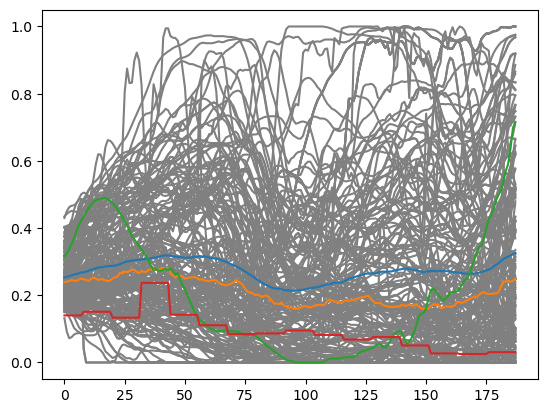

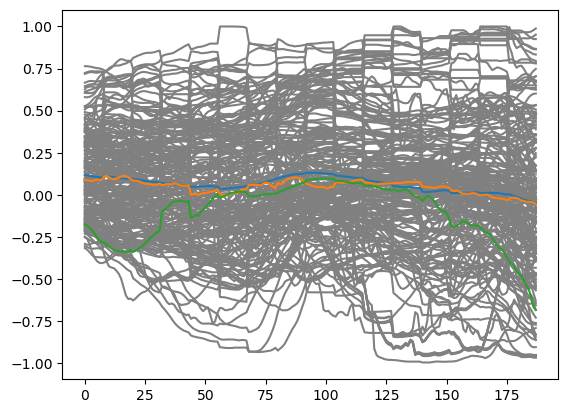

In [135]:
# Forecast dynamic update based on functional kNNs
def _predict(_model, F_hat_, f_):
        
    # # Smoothing observed mean and actuals
    # if (_model['smoothing'] == 1) | (_model['smoothing'] == 3): 
    #     F_, f_ = _smoothing(F_, f_, _model['lambda'])

    # phi: importance weights based on time distance
    phi_ = _exponential_decay(f_.shape[0], _model['forget_rate'])[::-1]
    phi_ = phi_/phi_.sum()
    # plt.figure(figsize = (10, 2))
    # plt.title('Forget Rate')
    # plt.plot(phi_)
    # plt.ylim(-0.1,1.1)
    # plt.show()
    # print(phi_.sum())

    # d: euclidian distance between samples weighted by importance weights (phi)
    d_ = _dist(_model['F_tr_'], f_, phi_)
    w_ = 1./(d_ + 1e-6)

    # w: normalized wieghts distance across observations based on RBF kernel distance
    #w_ = _kernel(d_, _model['length_scale'])
    
        
    # If no k-Nearest Neibors use adaptative approach
    if _model['n_kNNs'] == 0:
        # Find the kNNs 
        i    = int(np.sum(np.cumsum(np.sort(w_)[::-1]) < _model['tr_kNNs']))
        idx_nn_ = w_ > np.sort(w_)[::-1][i]
        # Enforce upper (max) and lower (min) Nearest Neibors limit
        if (idx_nn_.sum() < _model['n_min_kNNs']):
            idx_nn_ = w_ > np.sort(w_)[-_model['n_min_kNNs'] - 1]
        if (idx_nn_.sum() > _model['n_max_kNNs']):
            idx_nn_ = w_ > np.sort(w_)[-_model['n_max_kNNs'] - 1]      
    else:
        k = _model['n_kNNs'] + 1
        # Find the kNNs 
        idx_nn_ = w_.argsort().argsort() > w_.shape[0] - k
        # Get equivalent threshold
        tr_kNNs = w_[idx_nn_].min()

    # Calculate kNNs weights
    w_knn_            = np.zeros((idx_nn_.shape[0],))
    w_knn_[idx_nn_]   = 1.
    _model['weights'] = w_knn_/w_knn_.sum()
    
    idx_ = _model['weights'] > 0.
    #print(idx_.shape, idx_.sum(), _model['F_ts_'].shape, F_hat_.shape)
    #F_hat_[_model['weights'] > 0.]
    #F_tr_p_ = _model['F_tr_'][_model['weights'] > 0.]
    _model['F_']     = _model['F_ts_'][idx_, :]
    _model['F_hat_'] = F_hat_[idx_, :]
    
    for k in range(_model['F_hat_'].shape[0]):
        _model['F_hat_'][k, :] = _model['F_hat_'][k, :] - _model['F_'][k, :]
        
#     plt.figure()
#     plt.plot(_model['F_ts_'][idx_].T, c = 'gray')
#     plt.plot(np.mean(_model['F_ts_'][idx_], axis = 0))
#     plt.plot(np.median(_model['F_ts_'][idx_], axis = 0))
#     plt.show()

    # Mean function
    #f_hat_ = np.mean(F_ts_p_, axis = 0) 

    # plt.figure()
    # plt.plot(F_tr_p_.T, lw = 0.25, alpha = 0.75, color = 'gray')
    # #plt.plot(f_hat_)
    # plt.show()
    
    # E_ = np.zeros(F_ts_p_.shape)
    # for k in range(F_ts_p_.shape[0]):
    #     E_[k, :] = F_ts_p_[k, :] - fc_
    
#     plt.figure()
#     plt.plot(E_.T, lw = 0.25, alpha = 0.75, color = 'gray')
#     plt.show()
    
    # plt.figure()
    # plt.plot(F_ts_p_.T, lw = 0.25, alpha = 0.75, color = 'gray')
    # plt.plot(f_hat_)
    # plt.show()
    
#     E_ = np.zeros(F_ts_p_.shape)
#     for k in range(F_ts_p_.shape[0]):
#         E_[k, :] = F_ts_p_[k, :] - f_hat_
    
#     plt.figure()
#     plt.plot(E_.T, lw = 0.25, alpha = 0.75, color = 'gray')
#     plt.show()
    
    
#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3): 
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])
        
#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])
        

    return _model

_model = _fit(F_tr_, F_ts_,
              forget_rate  = .0001,
              trust_rate   = .0001,
              n_kNNs       = 200)
#print(F_ts_.shape, F_hat_ts_.shape, F_tr_.shape, f_tr_.shape)
_model = _predict(_model, F_hat_ts_, f_tr_)


print(f_ts_.shape, F_hat_ts_.shape)

plt.figure()
plt.plot(_model['F_'].T, c = 'gray')
plt.plot(np.mean(_model['F_'], axis = 0))
plt.plot(np.median(_model['F_'], axis = 0))
plt.plot(f_ts_)
plt.plot(f_fc_ts_)
plt.show()

plt.figure()
plt.plot(_model['F_hat_'].T, c = 'gray')
plt.plot(np.mean(_model['F_hat_'], axis = 0))
plt.plot(np.median(_model['F_hat_'], axis = 0))
plt.plot(f_fc_ts_ - f_ts_)
plt.show()

0.0985495916612938 0.497620889748549 100


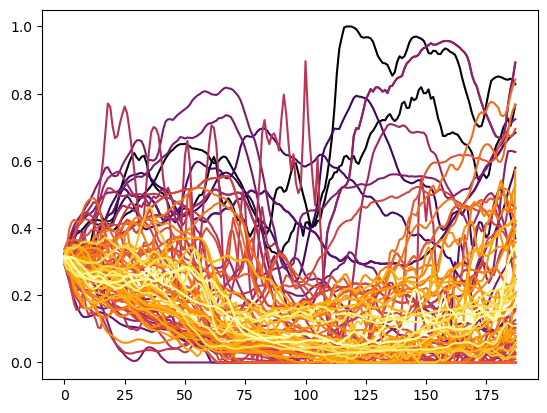

In [96]:
depth_ = _fDepth(_model['F_'], 'MBD', path_to_fDepth)
print(depth_.min(), depth_.max(), (depth_ <= 1).sum())

_cmap = plt.get_cmap('inferno')
_norm = plt.Normalize(depth_.min(), depth_.max())
c_    = _cmap(_norm(depth_))

plt.figure()
idx_ = np.argsort(depth_)
for i in range(idx_.shape[0]):
    plt.plot(np.arange(_model['F_'].shape[1]), _model['F_'][idx_[i], :], c = c_[idx_[i], :])  
plt.show()

In [148]:
def _get_eCDF_quantiles(_eCDF, q_):
    """
    Calculates quantiles from an ECDF.

    Args:
    _eCDF: function from statsmodels api
    q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

    Returns:
    _Q: A dictionary where keys are the input quantiles and values are the corresponding
    quantile values from the ECDF.
    """
    _Q = {}
    for q in q_:
        _Q[q] = _eCDF.x[np.searchsorted(_eCDF.y, q)]
    return _Q

def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins = 100):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    
def _PIT(z_, nbins = 100):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """
                
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (5, 2.5))
    plt.hist(z_, bins    = nbins, 
                 density = True, 
                 alpha   = 0.7, 
                 color   = 'blue', 
                 label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    plt.ylim(0., 2,)
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    
    
def _KS(y_true, forecast_mean, forecast_std, nbins = 100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """
    
    u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(u_samples_, nbins, density=True)
    bins_       = (bin_[:-1] + bin_[1:])/2.
    #r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))
    
    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks, avg_ks 

# _PIT(fs_ts_, mu_hat_, s_hat_, nbins = 50)
# KS = _KS(fs_ts_, mu_hat_, s_hat_, nbins = 100)[0]
# print(KS)

# plt.figure()
# plt.hist(_model['F_hat_'][:, i], bins = 25, range = (0, 1))
# plt.show()

# Q_ = _get_eCDF_quantiles(_eCDF, [0.025, 0.5, 0.975])
# print(Q_)

0
1
2
3
4


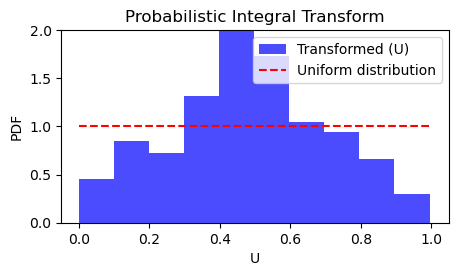

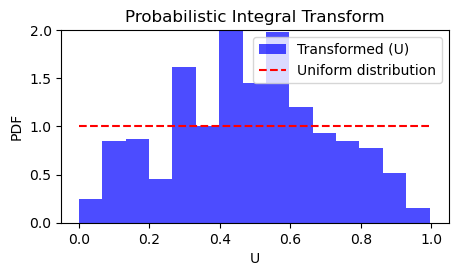

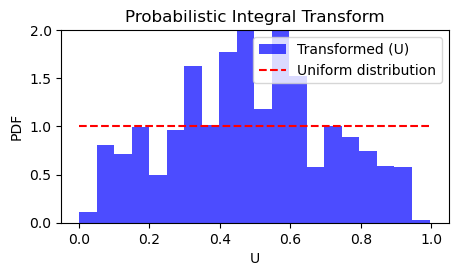

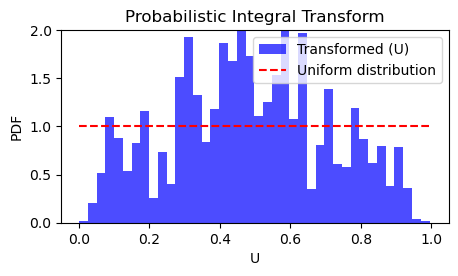

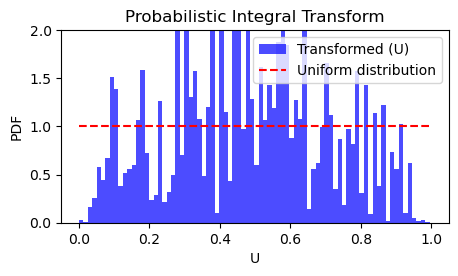

In [171]:
t = 100  

z_ = []

for a in range(5):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = 1.,
                      n_kNNs      = 1000)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        for i in range(78, 150, 1):
            # _eCDF = ECDF(_model['F_hat_'][:, i])
            # if (_eCDF(f_ts_[i]) == 0) | (_eCDF(f_ts_[i]) == 1.):
            #     continue
            # else:
            z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))

_PIT(np.stack(z_), nbins = 10)
_PIT(np.stack(z_), nbins = 15)
_PIT(np.stack(z_), nbins = 20)
_PIT(np.stack(z_), nbins = 40)
_PIT(np.stack(z_), nbins = 80)

0
1
2
3
4


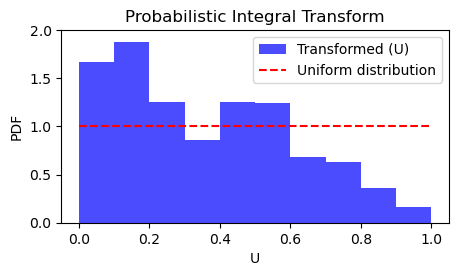

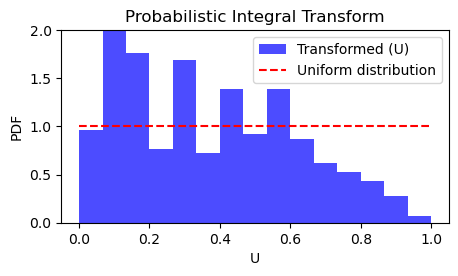

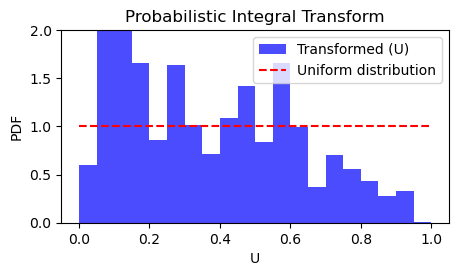

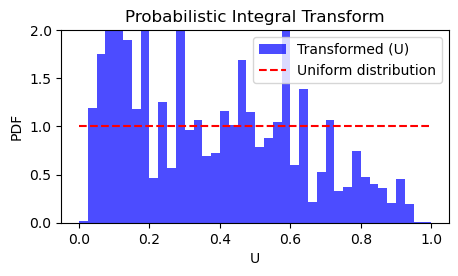

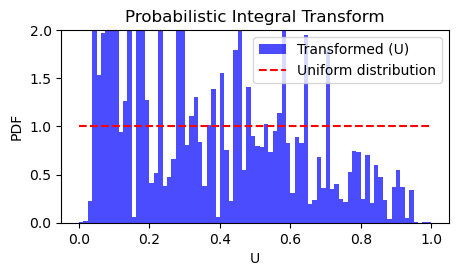

In [172]:
t = 100  

z_ = []

for a in range(5):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = 1.,
                      n_kNNs      = 1000)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        for i in range(78):
            # _eCDF = ECDF(_model['F_hat_'][:, i])
            # if (_eCDF(f_ts_[i]) == 0) | (_eCDF(f_ts_[i]) == 1.):
            #     continue
            # else:
            z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))

_PIT(np.stack(z_), nbins = 10)
_PIT(np.stack(z_), nbins = 15)
_PIT(np.stack(z_), nbins = 20)
_PIT(np.stack(z_), nbins = 40)
_PIT(np.stack(z_), nbins = 80)

0
1
2
3
4


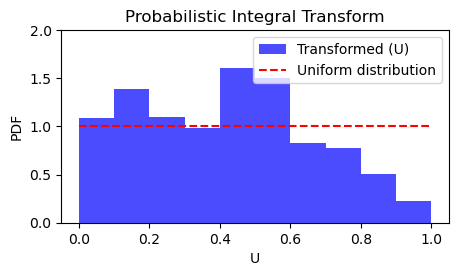

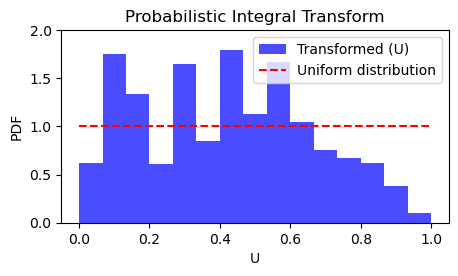

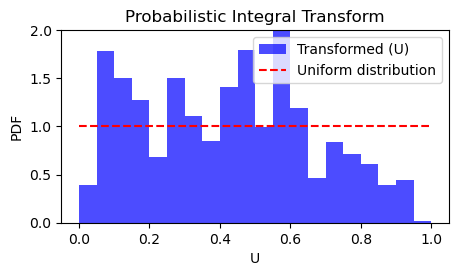

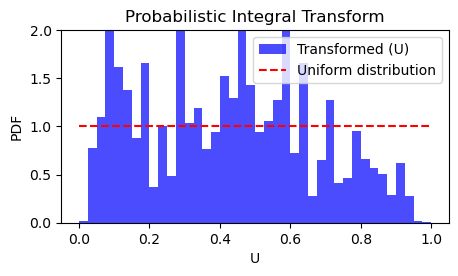

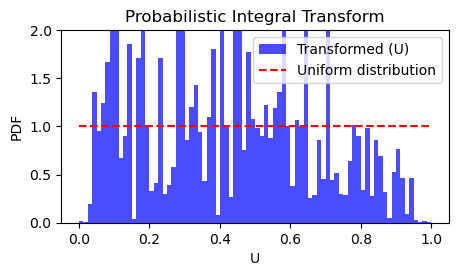

In [173]:
t = 100  

z_ = []

for a in range(5):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = 1.,
                      n_kNNs      = 1000)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        for i in range(150):
            # _eCDF = ECDF(_model['F_hat_'][:, i])
            # if (_eCDF(f_ts_[i]) == 0) | (_eCDF(f_ts_[i]) == 1.):
            #     continue
            # else:
            z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))

_PIT(np.stack(z_), nbins = 10)
_PIT(np.stack(z_), nbins = 15)
_PIT(np.stack(z_), nbins = 20)
_PIT(np.stack(z_), nbins = 40)
_PIT(np.stack(z_), nbins = 80)

In [ ]:

# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):
    
#     F_ = _model['F_tr_']
    
#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3): 
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])
    
#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])
        
#     _model['weights'] = w_/w_.sum()
    
#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']  
    
#     # Mean function
#     f_hat_ = F_.T @ w_ 

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])
    
#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3): 
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])
        
#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)
    
#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)
    
#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N
    
#     return _model.copy()